In [27]:
from ultralytics import YOLO
from easyocr import Reader
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re

In [5]:
img_paths = [
    '../imgs/plate1.png',
    '../imgs/plate2.png'
]

yolo = YOLO(r'D:\VSCodeProjects\license_plate_regconition\weight\best.pt')
ocr = Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [29]:
def detect(img_arr):
    h, w = img_arr.shape[:2]
    yolo_result = yolo.predict(source=img_arr, verbose=False)
    boxes = yolo_result[0].boxes

    if boxes is None:
        return []

    cleaned_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0].tolist()

        x_min = max(0, int(x_min))
        y_min = max(0, int(y_min))
        x_max = min(w, int(x_max))
        y_max = min(h, int(y_max))

        cleaned_boxes.append([x_min, y_min, x_max, y_max])

    return cleaned_boxes

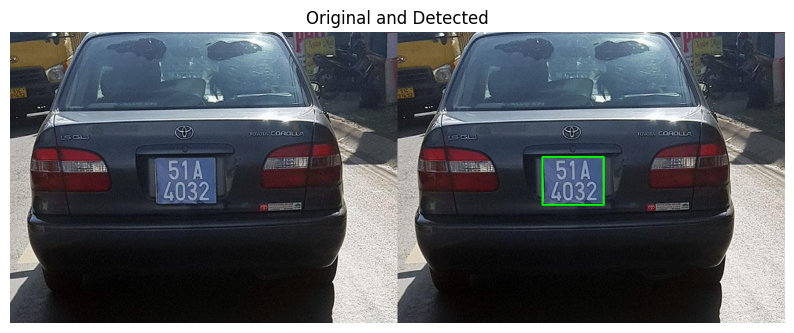

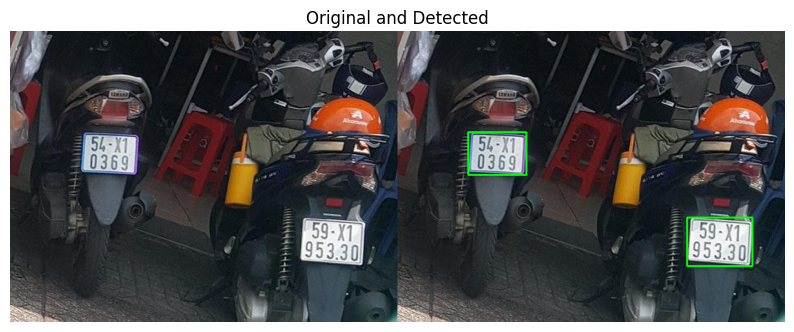

In [18]:
def draw_boxes(img, boxes, color=(0, 255, 0), thickness=2):
    img_drawn = img.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_drawn, (x1, y1), (x2, y2), color, thickness)
    return img_drawn

def show_side_by_side(img1, img2, title1='Original', title2='Detected'):
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    combined = np.hstack((img1_rgb, img2_rgb))
    plt.figure(figsize=(10, 5))
    plt.imshow(combined)
    plt.axis('off')
    plt.title(f'{title1} and {title2}')
    plt.show()

for img_path in img_paths:
    img_arr = cv2.imread(img_path)
    boxes = detect(img_arr)
    
    img_with_boxes = draw_boxes(img_arr, boxes)

    show_side_by_side(img_arr, img_with_boxes)

['51A4032']


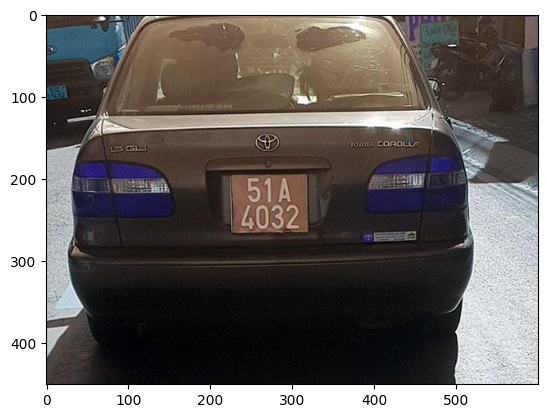

['59X795330', '54M0369']


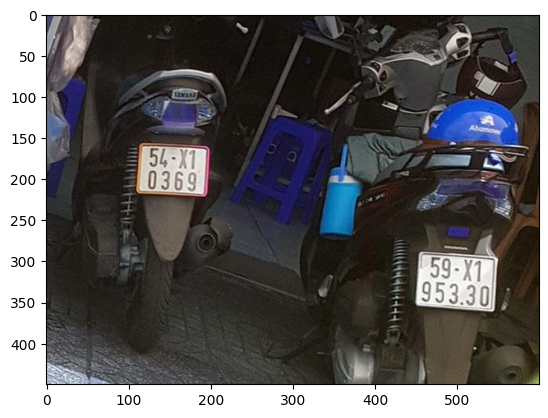

In [37]:
def normalize(ocr_result: str) -> str:
    return re.sub(r'[^a-zA-Z0-9]', '', ocr_result)

def regconize(img_arr: np.ndarray) -> list[str]:
    boxes = detect(img_arr)
    result_texts = []

    h, w = img_arr.shape[:2]

    for x_min, y_min, x_max, y_max in boxes:
        cropped_plate = img_arr[y_min:y_max, x_min:x_max]
        ocr_results = ocr.readtext(cropped_plate)

        if ocr_results:
            plate_text = ''.join([text for _, text, _ in ocr_results])
        else:
            plate_text = ''

        normalized_text = normalize(plate_text)
        result_texts.append(normalized_text)

    return result_texts


for img_path in img_paths:
    img_arr = cv2.imread(img_path)
    print(regconize(img_arr))
    plt.imshow(img_arr)
    plt.show()